### Faced Recognition Model

In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Path to the dataset folder
dataset_path =  "/Users/morrisonosiezagha/Downloads/1FRS_Dataset" # e.g., "./dataset"
# Initialize empty lists to store images and labels
images = []
labels = []

# Iterate through each folder (identity) in the dataset directory
for label, person_name in enumerate(os.listdir(dataset_path)):
    person_folder = os.path.join(dataset_path, person_name)

    # Ensure the path is a directory
    if os.path.isdir(person_folder):
        # Iterate through all images in the person's folder
        for image_name in os.listdir(person_folder):
            image_path = os.path.join(person_folder, image_name)
            # Read the image using OpenCV
            img = cv2.imread(image_path)
            
            # Check if the image was loaded correctly
            if img is not None:
                # Resize the image to a fixed size (e.g., 64x64 pixels)
                img_resized = cv2.resize(img, (64, 64))
                
                # Append the image and label to the lists
                images.append(img_resized)
                labels.append(label)

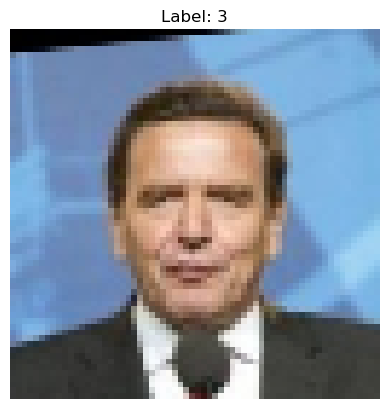

In [4]:
import matplotlib.pyplot as plt
import cv2

# Select an index of the image you want to display
image_index = 155# For example, the first image

# Convert the image from BGR to RGB (OpenCV loads images in BGR by default)
img_rgb = cv2.cvtColor(images[image_index], cv2.COLOR_BGR2RGB)

# Plot the image using matplotlib
plt.imshow(img_rgb)
plt.title(f"Label: {labels[image_index]}")  # Optional: Add a title with the label
plt.axis('off')  # Turn off axis lines and labels
plt.show()

In [5]:
import tensorflow as tf
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Path to the dataset folder
dataset_path = "/Users/morrisonosiezagha/Downloads/1FRS_Dataset"  # Replace with your dataset folder path

# Initialize empty lists to store cropped face images and labels
images = []
labels = []

# Initialize the Haar Cascade classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Iterate through each folder (identity) in the dataset directory
for label, person_name in enumerate(os.listdir(dataset_path)):
    person_folder = os.path.join(dataset_path, person_name)

    # Ensure the path is a directory
    if os.path.isdir(person_folder):
        # Iterate through all images in the person's folder
        for image_name in os.listdir(person_folder):
            image_path = os.path.join(person_folder, image_name)
            # Read the image using OpenCV
            img = cv2.imread(image_path)
            
            # Check if the image was loaded correctly
            if img is not None:
                # Convert the image to grayscale for face detection
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                
                # Detect faces in the image
                faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
                
                # If at least one face is detected, use the first detected face
                if len(faces) > 0:
                    (x, y, w, h) = faces[0]  # Get the first detected face's bounding box
                    
                    # Crop the face from the image
                    face_img = img[y:y+h, x:x+w]
                    
                    # Resize the cropped face to a fixed size (e.g., 64x64 pixels)
                    face_img_resized = cv2.resize(face_img, (64, 64))
                    
                    # Append the preprocessed face image and corresponding label
                    images.append(face_img_resized)
                    labels.append(label)

# Convert the lists to NumPy arrays
images = np.array(images) / 255.0  # Normalize the images (values between 0 and 1)
labels = np.array(labels)

# Check the unique number of classes
unique_labels = np.unique(labels)
num_classes = len(unique_labels)  # Dynamically determine the number of unique classes

# Relabel the labels so they range from 0 to num_classes-1
label_mapping = {old_label: new_label for new_label, old_label in enumerate(unique_labels)}
labels = np.array([label_mapping[label] for label in labels])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Define model hyperparameters
learning_rate = 0.0001  # Decreased learning rate for more stable training
batch_size = 32         # Batch size can be tuned further
epochs = 50             # Increase the number of epochs for more training time

# Build the model with the correct number of output classes
model = tf.keras.Sequential([
    # First Convolutional Block
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Second Convolutional Block
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Third Convolutional Block
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Fourth Convolutional Block
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Flattening Layer
    tf.keras.layers.Flatten(),
    
    # Fully Connected Layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),  # Dropout to prevent overfitting
    
    # Output Layer with correct number of classes
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model with an optimized learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early Stopping and Model Checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_facial_recognition_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Train the model with improved batch size and epochs
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, checkpoint]
)

# Save the final model
model.save('facial_recognition_model_final1.h5')


Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.0960 - loss: 4.1863
Epoch 1: val_loss improved from inf to 3.17348, saving model to best_facial_recognition_model.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 0.0982 - loss: 4.1665 - val_accuracy: 0.0268 - val_loss: 3.1735
Epoch 2/50
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.4718 - loss: 1.9775
Epoch 2: val_loss did not improve from 3.17348
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.4728 - loss: 1.9743 - val_accuracy: 0.0268 - val_loss: 3.1947
Epoch 3/50
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.6854 - loss: 1.1426
Epoch 3: val_loss did not improve from 3.17348
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.6856 - loss: 1.1423 - val_accuracy: 0.2774 - val_loss: 3.1776
Epoch 4/50
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.7851 - loss: 0.7520
Epoch 4: val_loss did not improve from 3.17348
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 0.7856 - loss: 0.7519 

In [6]:
print(f"Number of training samples: {len(X_train)}")
print(f"Number of testing samples: {len(X_test)}")

Number of training samples: 1643
Number of testing samples: 411


In [7]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy}')


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7789 - loss: 0.8084
Test accuracy: 0.7712895274162292


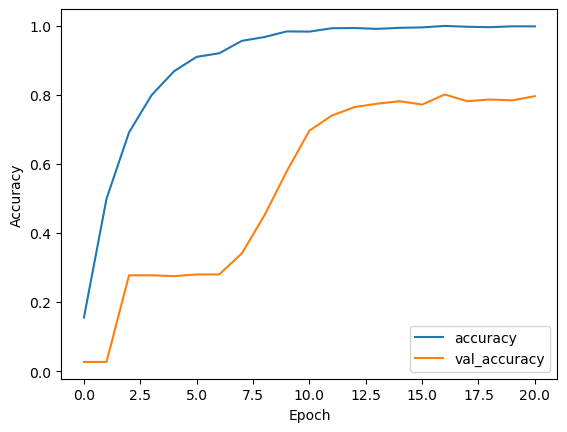

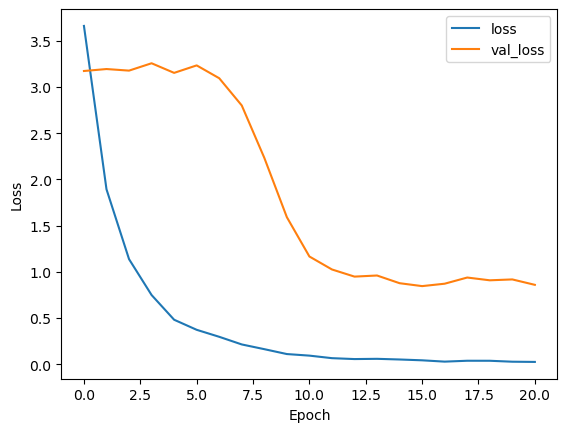

In [8]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.80      0.50         5
           1       1.00      0.57      0.73        14
           2       0.64      0.74      0.68        19
           3       1.00      0.45      0.62        11
           4       0.79      0.70      0.74        37
           5       0.50      0.29      0.36         7
           6       0.75      0.67      0.71         9
           7       0.00      0.00      0.00         6
           8       0.73      0.62      0.67        13
           9       0.71      0.68      0.70        22
          10       0.75      1.00      0.86         6
          11       1.00      0.43      0.60         7
          12       0.00      0.00      0.00         1
          13       0.81      0.93      0.86        41
          14       0.50      0.70      0.58        10
          15       1.00      0.78      0.88         9
          16      

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


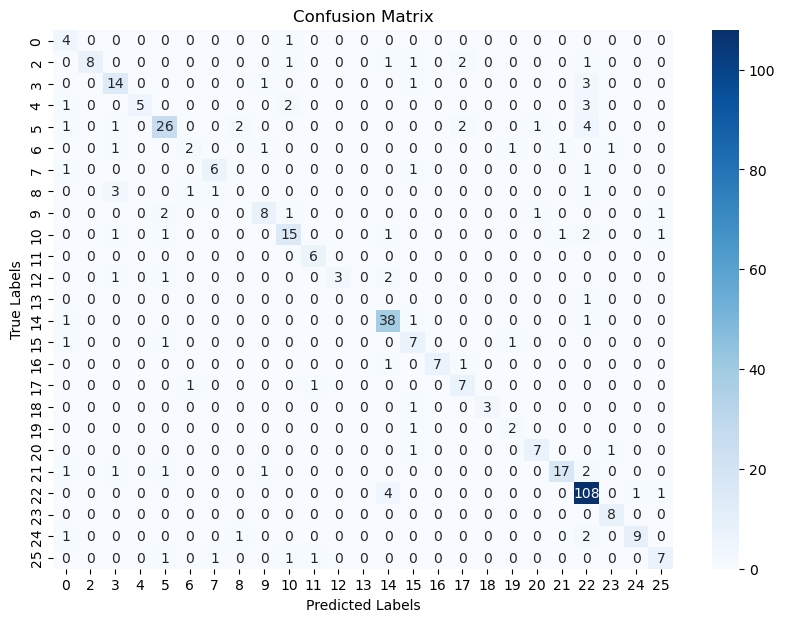

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
from itertools import cycle

# Assuming the model is already trained and saved as 'facial_recognition_model_final1.h5'
# Load the model
model = load_model('facial_recognition_model_final1.h5')

# Predict the probabilities for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### ROC Curve and AUC

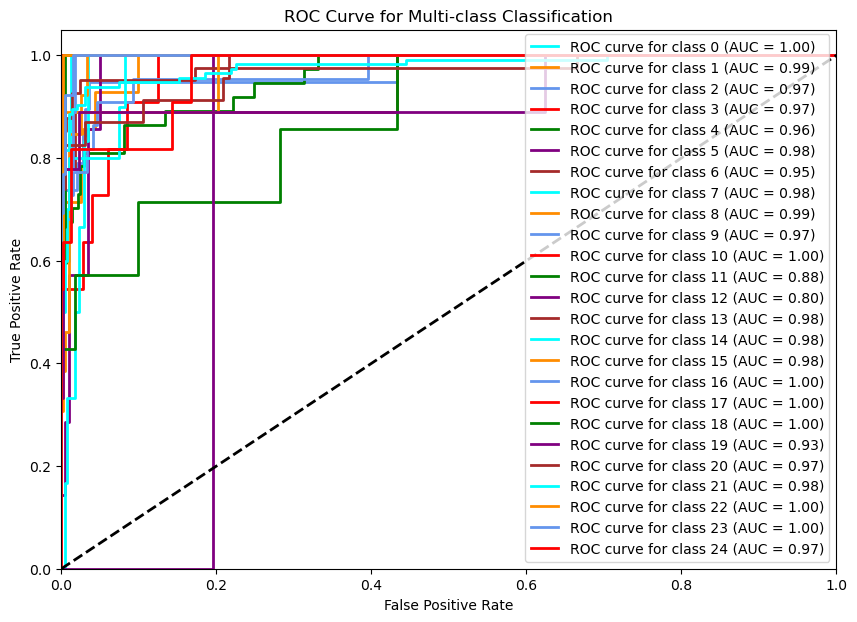

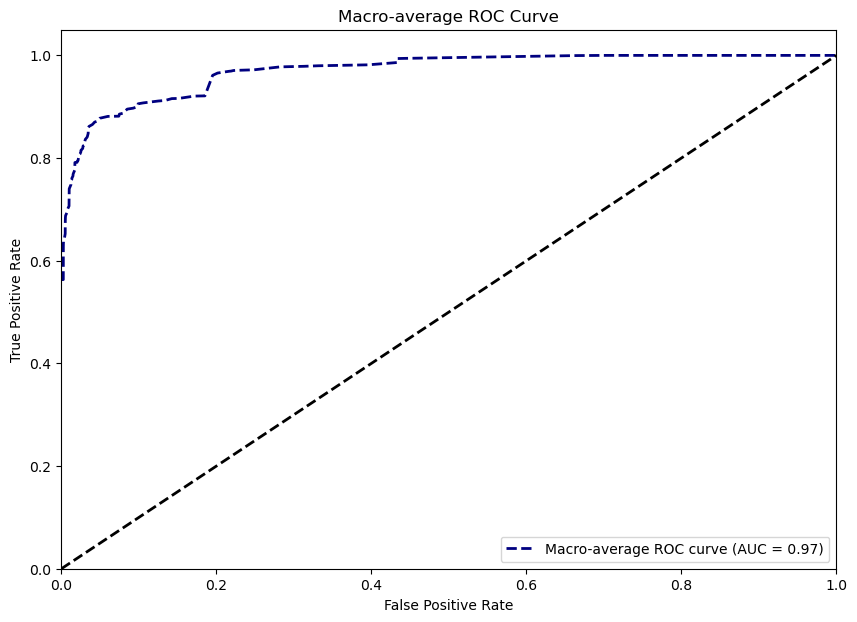

In [10]:
# ROC Curve and AUC for each class
n_classes = len(unique_labels)
y_test_bin = label_binarize(y_test, classes=range(n_classes))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 7))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve for class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class Classification')
plt.legend(loc='lower right')
plt.show()

# Compute macro-average ROC curve and AUC
# Aggregate all false positive rates and compute the mean of all tpr
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])  # Replace scipy interp with numpy interp

mean_tpr /= n_classes

# Compute AUC for macro-average ROC
fpr["macro"], tpr["macro"], _ = roc_curve(y_test_bin.ravel(), y_pred.ravel())
roc_auc["macro"] = auc(all_fpr, mean_tpr)

# Plot the macro-average ROC curve
plt.figure(figsize=(10, 7))
plt.plot(all_fpr, mean_tpr, color='navy', linestyle='--', linewidth=2,
         label='Macro-average ROC curve (AUC = {0:0.2f})'.format(roc_auc["macro"]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-average ROC Curve')
plt.legend(loc='lower right')
plt.show()